# E2 285 - Mtech ECE lab (2022)

Contributors: Aditya Gopalan, Abhigyan Dutta, Jaswanth Nischal Dokka, Vaishnav KV, Akkurthi Sree Harsha

# Week 3: Classifying hand-written digits


This week, you will work with an actual dataset of grayscale images of handwritten digits (the classic MNIST dataset) and build a neural network architecture to classify them as 0, 1, ... or 9. We will use PyTorch for setting up and training the neural network with the data. 


Acknowledgements: 

Significant parts of this notebook are based on the following resources, to which we are grateful: 

* Ben Trevett's excellent PyTorch image classification tutorial: https://github.com/bentrevett/pytorch-image-classification

* The official PyTorch tutorial on image classification: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


# E2 285 - Mtech ECE lab (2022)

Contributors: Aditya Gopalan, Abhigyan Dutta, Jaswanth Nischal Dokka, Vaishnav KV, Akkurthi Sree Harsha

# Week 3: Classifying hand-written digits


This week, you will work with an actual dataset of grayscale images of handwritten digits (the classic MNIST dataset) and build a neural network architecture to classify them as 0, 1, ... or 9. We will use PyTorch for setting up and training the neural network with the data. 


Acknowledgements: 

Significant parts of this notebook are based on the following resources, to which we are grateful: 

* Ben Trevett's excellent PyTorch image classification tutorial: https://github.com/bentrevett/pytorch-image-classification

* The official PyTorch tutorial on image classification: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


### Data Processing

Let's start by importing all the modules we'll need. The main ones we need to import are:
- torch for general PyTorch functionality
- torch.nn and torch.nn.functional for neural network based functions
- torch.optim for our optimizer which will update the parameters of our neural network
- torch.utils.data for handling the dataset
- torchvision.transforms for data augmentation
- torchvision.datasets for loading the dataset
- matplotlib for plotting
- tqdm for pretty decoration of iterative training loops

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import time


To ensure we get reproducible results we set the random seed for Python, Numpy and PyTorch.

In [3]:
SEED = 1234

np.random.seed(SEED) # NumPy's internal seed
torch.manual_seed(SEED) # PyTorch's internal seed

The first thing we'll do is load our dataset.

This will automatically download the training set for the MNIST dataset and save it in a folder called `.data`. It will create the folder if it does not exist.

In [2]:
ROOT = './data'

train_data = datasets.MNIST(root=ROOT, train=True, download=True)

In [3]:
# our training data has 60k images, each of size 28x28: 

train_data.data.float().shape

torch.Size([60000, 28, 28])

You can examine any image in the training dataset. Here's how:

label of the image: 2


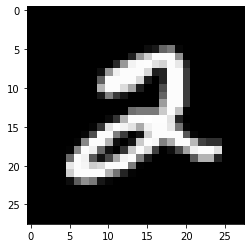

In [4]:
image_index = 5 # the sixth image of the training data; change this to see other images of your choice

img, label = train_data[image_index]
plt.imshow(img, cmap='gray') # imshow renders an array (or tensor) as an image, cmap indicates the colourmap choice
print(f"label of the image: {label}")

What's the type of each image datum? Let's check the type of the image we just plotted:

In [5]:
type(img)

PIL.Image.Image

Each image in the dataset is in PIL (Python Image Library) format, which is an internal byte-based integer format. PyTorch's native format for manipulating data is, however, the _tensor_. Luckily, PyTorch defines utility functions called _transforms_ to convert data to tensor type automatically whenever any data point is touched. We define here a simple transform whose job is to just convert an image from PIL format to the PyTorch tensor format. 

In [6]:
my_transform = transforms.ToTensor()

Now we have defined our transform, we can load the train and test data with the transform defined and applied automatically while loading. 

In [7]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=my_transform)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=my_transform)

We can simply check the `len` of the datasets to see how many examples are within each.

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


The MNIST dataset comes with a training and test set, but not a validation set. We want to use a validation set to check how well our model performs on unseen data. Why don't we just use the test data? We should only be measuring our performance over the test set once, after all training is done. We can think of the validation set as a proxy test set we are allowed to look at as much as we want. 

Furthermore, we create a validation set, taking 10% of the training set. **Note:** the validation set should always be created from the training set. Never take the validation set from the test set. When researchers publish research papers they should be comparing performance across the test set and the only way to ensure this is a fair comparison is for all researchers to use the same test set. If the validation set is taken from the test set, then the test set is not the same as everyone else's and the results cannot be compared against each other.

First, we have to define the exact number of examples that we want to be in each split of the training/validation sets.

In [9]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

Then, we use the `random_split` function to take a random 10% of the training set to use as a validation set. The remaining 90% will stay as the training set.

In [10]:
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

We can print out the number of examples again to check our splits are correct.

In [11]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


Next, we'll define a `DataLoader` for each of the training/validation/test sets. We can iterate over these, and they will yield batches of images and labels which we can use to train our model.

We only need to shuffle our training set as it will be used for stochastic gradient descent, and we want each batch to be different between epochs. As we aren't using the validation or test sets to update our model parameters, they do not need to be shuffled.

Ideally, we want to use the biggest batch size that we can. The 64 here is relatively small and can be increased if our hardware can handle it.

In [12]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

### Defining the Model

Our model will be a neural network, specifically a multilayer perceptron (MLP) (sometimes also called a *fully-connected neural network*) with two hidden layers. The image below shows the architecture of the model. 

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/mlp-mnist.png?raw=1)

Specifically, first we will flatten our 1x28x28 (1 color channel, 28 pixels height and width) image into a 784-element vector (Note: 784=) , also called 784 *features*. We flatten our input, as MLPs cannot handle two or three-dimensional data. Next, the 784 dimensional input is passed through the first hidden layer to transform it into 250 dimensions. Then, another hidden layer, which will transform it to 100 dimensions. Finally, an output layer which will transform it into a 10 dimensional vector. The output dimension should equal the number of classes within your data. Here we have ten digits, 0 - 9, so need our output to be 10 dimensions.

The transformation between 784 to 250, 250 to 100 and 100 to 10 dimensions are done by `Linear` layers. These are also known as fully connected or affine layers. In these layers, every element in one layer is connected to every element in the next. We can think of these elements as *neurons*, as this architecture is inspired by how the human brain is made of millions of interconnected nodes, also called neurons. 

Each connection between a neuron in one layer and a neuron in the next has a *weight* associated with it. The input to one neuron is the sum of the weighted values of all neurons in the previous layer connected to it, plus a weighted bias term, where the bias value is always 1. The neuron then applies an *activation function* to this weighted sum. This activation function is a non-linear function that allows the neural network to learn non-linear functions between inputs and outputs. 

We define our MLP below, which consists of three linear layers. We first take the input batch of images and flatten them, so they can be passed into the linear layers. We then pass them through the first linear layer, `input_fc`, which calculates the weighted sum of the inputs, and then apply the *ReLU* (rectified linear unit) activation function elementwise. This result is then passed through another linear layer, `hidden_fc`, again applying the same activation function elementwise. Finally, we pass this through the final linear layer, `output_fc`. We return not only the output but also the second hidden layer as we will do some analysis on it later.

The ReLU activation function is a popular non-linear function that is simply $max(0, x)$, where $x$ is the weighted sum of the inputs to that neuron. Other activation functions used are hyperbolic tan (tanh) and sigmoid function, however ReLU is the most commonly used.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/relu.png?raw=1)


One thing to note is that we do not use an activation function on the input directly or on the output. You should never use activation functions directly on the input, i.e. `F.relu(x)`. PyTorch combines activation functions to be applied on the output with the functions which calculate the *loss*, also known as *error* or *cost*, of a neural network. This is done for numerical stability.

Why did we choose hidden dimensions of 250 and 100 elements? Why did we only have two hidden layers? There is no magic formula to tell us how many layers to use and how many neurons to have in each layer, and there is most probably a better set of values. However, the general idea is that neural networks extract features from data. Layers closer to the input learn to extract general features (e.g. lines, curves, edges), whilst later layers combine the features extracted from the previous layer into more high level features (e.g. the intersection of two lines making a cross, multiple curves make a circle). We force our neural network to learn these features by reducing the number of neurons in each layer. This way, it has to learn to compress information by extracting only the useful and general features. Thus, we want a neural network with multiple layers and some sort of information compression (reduced number of neurons in subsequent layers).

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1) # for a tensor x of size (s1, s2, s2), x.view(s1, -1) reshapes x to size (s1, s2*s3)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))

        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)

        # y_pred = [batch size, output dim]

        return y_pred

We'll define our model by creating an instance of it and setting the correct input and output dimensions.

In [14]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

We can also create a small function to calculate the number of trainable parameters (weights and biases) in our model - in case all of our parameters are trainable.

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
print(f'model has {count_parameters(model):,} trainable parameters')

model has 222,360 trainable parameters


*Explanation*: The first layer has 784 neurons connected to 250 neurons, so 784*250 weighted connections plus 250 bias terms.

The second layer has 250 neurons connected to 100 neurons, 250*100 weighted connections plus 100 bias terms.

The third layer has 100 neurons connected to 10 neurons, 100*10 weighted connections plus 10 bias terms.

$$784 \cdot 250 + 250 + 250 \cdot 100 + 100 + 100 \cdot 10 + 10 = 222,360 $$

### Training the Model

Next, we'll define our optimizer. This is the algorithm we will use to update the parameters of our model with respect to the loss calculated on the data.

We aren't going to go into too much detail on how neural networks are trained (see [this](http://neuralnetworksanddeeplearning.com/) article if you want to know how) but the gist is:
1. pass a batch of data through your model
2. calculate the loss of your batch by comparing your model's predictions against the actual labels
3. calculate the gradient of the loss with respect to each of your model's parameters 
4. update each of your parameters by subtracting their gradient multiplied by a small *learning rate* parameter



### Step 3: Calculating the gradient of the loss with respect to each of your model's parameters

#### Example setting:

Consider the following simple neural network where the outout loss is described as a function of the input variables and weights and biases as below. 

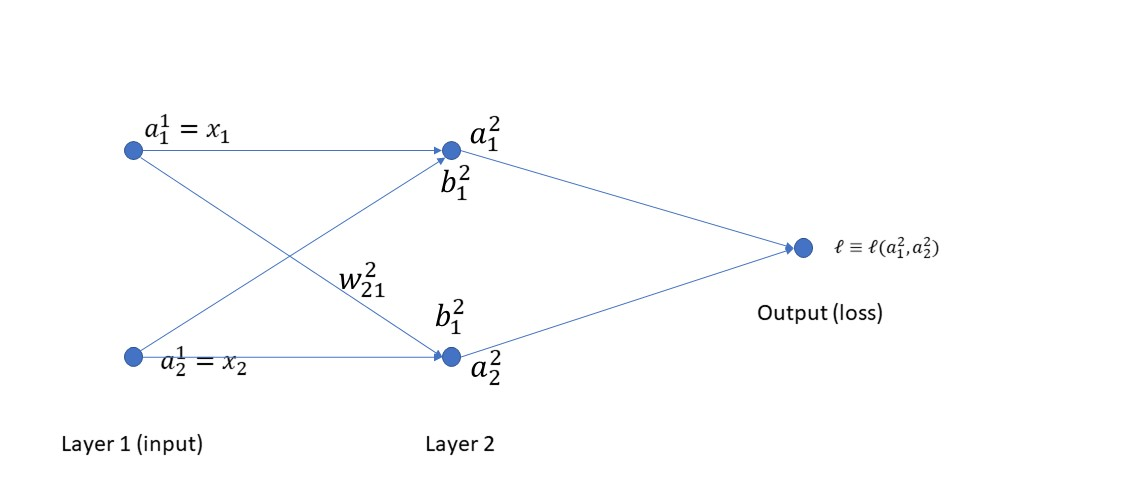


In [17]:
x_1 = torch.tensor(1.0, requires_grad=False)
x_2 = torch.tensor(2.0, requires_grad=False)

a1_1 = x_1
a1_2 = x_2

w2_11 = torch.tensor(1.0, requires_grad=True)
w2_12 = torch.tensor(2.0, requires_grad=True)
w2_21 = torch.tensor(3.0, requires_grad=True)
w2_22 = torch.tensor(4.0, requires_grad=True)

b2_1 = torch.tensor(5.0, requires_grad=True)
b2_2 = torch.tensor(6.0, requires_grad=True)

a2_1 = F.relu(a1_1*w2_11 + a1_2*w2_12 + b2_1)
a2_2 = F.relu(a1_1*w2_21 + a1_2*w2_22 + b2_2)

ell = torch.exp(a2_1)/(torch.exp(a2_1) + torch.exp(a2_2))

ell.backward()
print(w2_11.grad)
print(w2_12.grad)
print(w2_21.grad)
print(w2_22.grad)
print(b2_1.grad)
print(b2_2.grad)

tensor(0.0009)
tensor(0.0018)
tensor(-0.0009)
tensor(-0.0018)
tensor(0.0009)
tensor(-0.0009)


### Exercise 1: Can you explain how the gradients of the loss at the output w.r.t. the weights and biases are as printed above?

(Write your answer here. You can optionally write on a paper, scan the page and paste it here as an image.)

  a1_1      a2_1
              
  a1_2      a2_2

We use standard SGD (stochastic gradient descent), as we've encountered before, to update our model. Improved results could be obtained by searching over different optimizers and learning rates, such as the Adam algorithm (a more sophisticated variant of SGD that incorporates _momentum_ in the iterative dynamics). Check out [this](https://ruder.io/optimizing-gradient-descent/) article if you want to learn more about the different optimization algorithms commonly used for neural networks.

In [24]:
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

Then, we define a *criterion*, PyTorch's name for a loss/cost/error function. This function will take in your model's predictions with the actual labels and then compute the loss/cost/error of your model with its current parameters.

`CrossEntropyLoss` both computes the *softmax* activation function on the supplied predictions as well as the actual loss via *negative log likelihood*. 

Briefly, the softmax function is:

$$\text{softmax }(\mathbf{x}) = \frac{e^{x_i}}{\sum_j e^{x_j}}$$ 

This turns out 10 dimensional output, where each element is an unbounded real number, into a probability distribution over 10 elements. That is, all values are between 0 and 1, and together they all sum to 1. 

Why do we turn things into a probability distribution? So we can use negative log likelihood for our loss function, as it expects probabilities. PyTorch calculates negative log likelihood for a single example via:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, y) = -\log \big( \text{softmax}(\mathbf{\hat{y}})[y] \big)$$

$\mathbf{\hat{y}}$ is the $\mathbb{R}^{10}$ output, from our neural network, whereas $y$ is the label, an integer representing the class. The loss is the negative log of the class index of the softmax. For example:

$$\mathbf{\hat{y}} = [5,1,1,1,1,1,1,1,1,1]$$

$$\text{softmax }(\mathbf{\hat{y}}) = [0.8585, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157]$$

If the label was class zero, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 0) = - \log(0.8585) = 0.153 \dots$$

If the label was class five, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 5) = - \log(0.0157) = 4.154 \dots$$

So, intuitively, as your model's output corresponding to the correct class index increases, your loss decreases.

In [18]:
criterion = nn.CrossEntropyLoss()

Next, as a measurement metric for a model at any point during the training process, it will be helpful to define a function to calculate the accuracy of our model. This takes the index of the highest value for your prediction and compares it against the actual class label. We then divide how many our model got correct by the amount in the batch to calculate accuracy across the batch.

In [19]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

We finally define our training loop.

This will:
- put our model into `train` mode
- iterate over our dataloader, returning batches of (image, label)
- clear the gradients calculated from the last batch
- pass our batch of images, `x`, through to model to get predictions, `y_pred`
- calculate the loss between our predictions and the actual labels
- calculate the accuracy between our predictions and the actual labels
- calculate the gradients of each parameter
- update the parameters by taking an optimizer step
- update our metrics

Some layers act differently when training and evaluating the model that contains them, hence why we must tell our model we are in "training" mode. The model we are using here does not use any of those layers, however it is generally good practice in PyTorch to get used to putting your model in training mode.

In [20]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The evaluation loop is similar to the training loop. The differences are:
- we put our model into evaluation mode with `model.eval()`
- we wrap the iterations inside a `with torch.no_grad()`
- we do not zero gradients as we are not calculating any
- we do not calculate gradients as we are not updating parameters
- we do not take an optimizer step as we are not calculating gradients

`torch.no_grad()` ensures that gradients are not calculated for whatever is inside the `with` block. As our model will not have to calculate gradients, it will be faster and use less memory. 

In [21]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The final step before training is to define a small function to tell us how long an epoch took.

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We're finally ready to train!

During each epoch we calculate the training loss and accuracy, followed by the validation loss and accuracy. We then check if the validation loss achieved is the best validation loss we have seen. If so, we save our model's parameters (called a `state_dict`).

In [23]:
# the complete training loop for MLP

EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Overall progress"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'learnt-model-MLP.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Overall progress:   0%|          | 0/10 [00:00<?, ?it/s]

NameError: name 'optimizer' is not defined

Finally, we can load our the parameters of the model that achieved the best validation loss (during the training process), assuming this is our final trained output, and then use this to evaluate our model on the test set.

In [30]:
# final trained MLP

model.load_state_dict(torch.load('learnt-model-MLP.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.226 | Test Acc: 93.52%


This accuracy can perhaps be improved by tweaking hyperparameters, e.g. number of layers, number of neurons per layer, optimization algorithm used, learning rate, etc. You are invited to try this out ('hyperparameter optimization') in your spare time in order to better the result obtained above.

### Exercise 2: Changing the optimization algorithm to ADAM

Change the PyTorch optimizer to ADAM instead of SGD (look up PyTorch optimizer documentation), re-initialize the MLP and re-train it to see if it performs better. 

In [25]:
#re-initializing MLP
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model_with_adam = MLP(INPUT_DIM, OUTPUT_DIM)

In [26]:
#Changing Optimizeer to ADAM 
learning_rate = 0.01
adam_optimizer = optim.Adam(model_with_adam.parameters(), lr=learning_rate)

In [27]:
#re-training with Adam optimizer
# the complete training loop for MLP

EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Overall progress"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model_with_adam, train_iterator, adam_optimizer, criterion)
    valid_loss, valid_acc = evaluate(model_with_adam, valid_iterator, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_with_adam.state_dict(), 'learnt-model_with_adam-MLP.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Overall progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 0.254 | Train Acc: 92.27%
	 Val. Loss: 0.169 |  Val. Acc: 95.00%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 13s
	Train Loss: 0.147 | Train Acc: 95.84%
	 Val. Loss: 0.183 |  Val. Acc: 95.37%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 0.130 | Train Acc: 96.40%
	 Val. Loss: 0.180 |  Val. Acc: 95.61%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 12s
	Train Loss: 0.115 | Train Acc: 96.82%
	 Val. Loss: 0.232 |  Val. Acc: 94.97%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 12s
	Train Loss: 0.110 | Train Acc: 96.96%
	 Val. Loss: 0.192 |  Val. Acc: 95.78%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 13s
	Train Loss: 0.094 | Train Acc: 97.50%
	 Val. Loss: 0.180 |  Val. Acc: 96.28%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 12s
	Train Loss: 0.091 | Train Acc: 97.52%
	 Val. Loss: 0.229 |  Val. Acc: 95.78%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 12s
	Train Loss: 0.090 | Train Acc: 97.61%
	 Val. Loss: 0.205 |  Val. Acc: 96.20%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 12s
	Train Loss: 0.085 | Train Acc: 97.74%
	 Val. Loss: 0.242 |  Val. Acc: 96.12%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 11s
	Train Loss: 0.082 | Train Acc: 97.84%
	 Val. Loss: 0.217 |  Val. Acc: 96.50%


### Exercise 3: Confusion Matrix

The learnt model still makes some mistakes on the test set. Write code to compute and display the following 10x10 matrix (say $M$), called a _confusion matrix_ : The $(i,j)$-th entry of M, $M[i,j]$, is the number of examples in the test set whose true label is $i-1$ but whose predicted label (by the model) is $j-1$.  

<h3>Calculating Actual and Predicted Values for TestData<h3/>

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd 

In [29]:
ypred=[]                                                       # list to store predicted vaLues 
ytrue=[]                                                       # list to store actual values 
for input,label in test_iterator:                              # iterating over test data
       y_pred = model_with_adam(input)                         # storing predictions in y_pred
       top_pred= (torch.max(y_pred, 1)[1]).data.numpy()        # evaluating class
       #top_pred = y_pred.argmax(1, keepdim=True)
       ypred.extend(top_pred)                                  # extending prediction list
       ytrue.extend(label.data.numpy())                        # extending actual list

<h3> Plotting Confusion Matrix </h3>

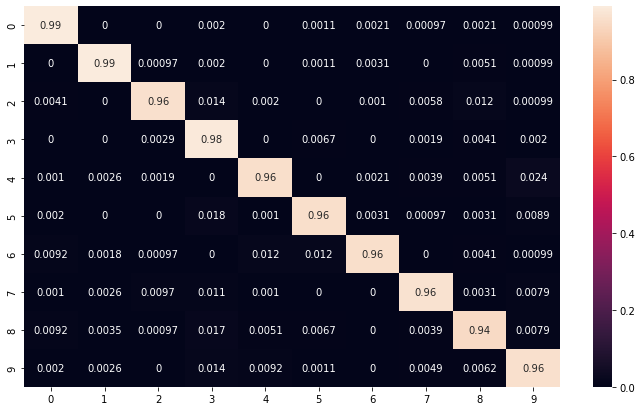

In [30]:
# Build confusion matrix
classes=['0','1','2','3','4','5','6','7','8','9']
cm_mat = confusion_matrix(ytrue, ypred)
df_cm = pd.DataFrame(cm_mat / np.sum(cm_mat, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig('output.png')

### Convolutional neural networks for image classification

In the previous section we tuned a Multi Layer Perceptron (MLP) to recognize the image label. Recall that the MLP accepts only vector inputs; therefore, in its first step, it 'flattens' the entire 2D image. This is capable of destroying valuable local 2D structure in the image that our eyes can easily recognize, for instance. 

A more powerful alternative to image classification is the Convolutional Neural Network (CNN). This neural network sets up 2D translation-invariant filters on the input images in a series of stages, together with nonlinear operations in between them. Training the CNN is like learning the "right filters" to apply to input images, e.g., we know that common operations like edge detection, smoothing, etc., can be represented as 2D convolutional filters. The CNN learns filtering operations _implicitly_. 

We will use the following CNN architecture, with the only difference being that it is adapted to take in our 28x28 images from MNIST (instead of 32x32 as indicated). 

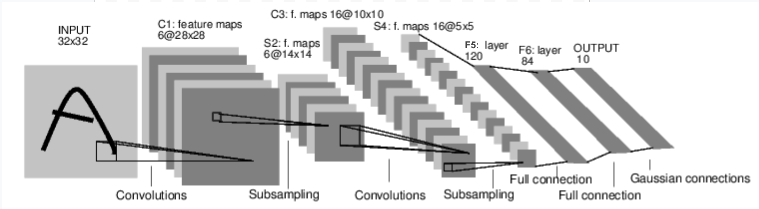


You can learn more about CNNs by following these resources:

* https://youtu.be/iaSUYvmCekI

* http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture5.pdf

Just like it was for the MLP, here is our class definition for a CNN that processes 28x28 single channel (i.e., grayscale) images

In [31]:
# a CNN for the same task

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 5*5 from final image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        #= If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        h = x
        x = self.fc3(x)
        return x

It is time to instantiate this class and create a CNN object:

In [32]:
model2 = Net()

Let us compute the number of trainable parameters in the CNN that we just instantiated, using our _count_parameters_ function. 

In [33]:
print(f'model2 has {count_parameters(model2):,} trainable parameters')

model2 has 44,426 trainable parameters


### Exercise 4: Counting parameters of the CNN

Can you explain why the CNN has 44,426 trainable parameters? 

<p>
 To calculate no of paraneter in CNN Layer we use <br/>
  Parameters = (height of filter * width of filter * no of filter in previous layer + 1 [ for Bias ] ) * number of filters <br/>

 To calculate no of paraneter in Dense Layer we use <br/>
  Parameters = ( no of activation units in previous layer ) *  ( no of activation units in this layer ) +  (  [ for Bias ]no of activation units in this layer )  <br/>
   
  First CNN Layer =     ((5*5*1)+1)*6         =  156  <br/>
  Second CNN Layer =     ((5*5*6)+1)*16       =  2416  <br/>
  Third (Dense) Layer = (16*4*4 ) * 120 + 120 =  30840  <br/>
  Four (Dense)  Layer =   ( 120 * 84 ) + 84   =  10164  <br/>
  Last (Dense) Layer  =     (84 * 10) + 10    =  850  <br/>

  Total   = 156 + 2416 + 30840 + 10164 + 850 =  44426 

  </p>
    

### Training the CNN

Let's set up the training pipeline for the CNN in about the same way as we did for the MLP. We will set up an SGD optimizer, a loss function (criterion) and finally the training loop

In [43]:
optimizer2 = optim.SGD(model2.parameters(), lr=0.01)

In [44]:
criterion2 = nn.CrossEntropyLoss()

In [45]:
# the complete training loop for CNN

EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Overall progress"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model2, train_iterator, optimizer2, criterion2)
    valid_loss, valid_acc = evaluate(model2, valid_iterator, criterion2)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model2.state_dict(), 'learnt-model-CNN.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Overall progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 15s
	Train Loss: 2.267 | Train Acc: 20.22%
	 Val. Loss: 2.047 |  Val. Acc: 50.71%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 0.720 | Train Acc: 80.17%
	 Val. Loss: 0.434 |  Val. Acc: 86.40%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 0.289 | Train Acc: 91.34%
	 Val. Loss: 0.257 |  Val. Acc: 92.34%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 17s
	Train Loss: 0.201 | Train Acc: 93.89%
	 Val. Loss: 0.196 |  Val. Acc: 94.13%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 17s
	Train Loss: 0.155 | Train Acc: 95.25%
	 Val. Loss: 0.169 |  Val. Acc: 95.05%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 17s
	Train Loss: 0.129 | Train Acc: 96.06%
	 Val. Loss: 0.134 |  Val. Acc: 96.01%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 21s
	Train Loss: 0.112 | Train Acc: 96.60%
	 Val. Loss: 0.121 |  Val. Acc: 96.02%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 16s
	Train Loss: 0.099 | Train Acc: 96.92%
	 Val. Loss: 0.108 |  Val. Acc: 96.78%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 16s
	Train Loss: 0.091 | Train Acc: 97.13%
	 Val. Loss: 0.099 |  Val. Acc: 97.06%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 15s
	Train Loss: 0.083 | Train Acc: 97.45%
	 Val. Loss: 0.096 |  Val. Acc: 97.19%


Finally, we can load our the parameters of the model that achieved the best validation loss (during the training process), assuming this is our final trained output, and then use this to evaluate our model on the test set.

In [46]:
# final trained CNN

model2.load_state_dict(torch.load('learnt-model-CNN.pt'))

test_loss, test_acc = evaluate(model2, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.078 | Test Acc: 97.70%


Note the improved accuracy on the test set achieved by CNN as compared to MLP. This is presumably because the CNN is designed to exploit local 2D structure in the input image. 

As usual, the structure of the network, the parameters of the learning algorithm (type of algorithm, learning rate), etc., can be tweaked further to get better test set performance. 

### Exercise 5: Changing the optimization algorithm to ADAM

Change the PyTorch optimizer to ADAM instead of SGD (look up PyTorch optimizer documentation), re-initialize the CNN and re-train it to see if it performs better. 

In [35]:
#re-initialize the CNN
CNN_with_Adam = Net()
#  Intializing  Adam Optimizer
optimizer_with_adam = optim.Adam(CNN_with_Adam.parameters(), lr=0.01)

In [36]:
criterion2 = nn.CrossEntropyLoss()

In [37]:

# the complete training loop for CNN

EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Overall progress"):

    start_time = time.monotonic()

    train_loss, train_acc = train(CNN_with_Adam, train_iterator, optimizer_with_adam, criterion2)
    valid_loss, valid_acc = evaluate(CNN_with_Adam, valid_iterator, criterion2)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(CNN_with_Adam.state_dict(), 'learnt-model-CNN.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Overall progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 15s
	Train Loss: 0.199 | Train Acc: 93.83%
	 Val. Loss: 0.094 |  Val. Acc: 97.27%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 16s
	Train Loss: 0.090 | Train Acc: 97.50%
	 Val. Loss: 0.118 |  Val. Acc: 96.66%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 16s
	Train Loss: 0.080 | Train Acc: 97.85%
	 Val. Loss: 0.112 |  Val. Acc: 97.76%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 16s
	Train Loss: 0.081 | Train Acc: 97.82%
	 Val. Loss: 0.113 |  Val. Acc: 97.46%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 16s
	Train Loss: 0.081 | Train Acc: 97.89%
	 Val. Loss: 0.108 |  Val. Acc: 97.50%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 16s
	Train Loss: 0.075 | Train Acc: 98.08%
	 Val. Loss: 0.120 |  Val. Acc: 97.49%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 16s
	Train Loss: 0.076 | Train Acc: 98.09%
	 Val. Loss: 0.096 |  Val. Acc: 97.75%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 15s
	Train Loss: 0.075 | Train Acc: 98.14%
	 Val. Loss: 0.151 |  Val. Acc: 97.16%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 15s
	Train Loss: 0.070 | Train Acc: 98.24%
	 Val. Loss: 0.136 |  Val. Acc: 97.40%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 16s
	Train Loss: 0.070 | Train Acc: 98.34%
	 Val. Loss: 0.280 |  Val. Acc: 96.89%


### Exercise 6: Confusion Matrix

The learnt model still makes some mistakes on the test set. Write code to compute and display the following 10x10 matrix (say $M$), called a _confusion matrix_ : The $(i,j)$-th entry of M, $M[i,j]$, is the number of examples in the test set whose true label is $i-1$ but whose predicted label (by the model) is $j-1$, for $1 \leq i, j \leq 10$.

<h3>Calculating Actual and Predicted Values for TestData<h3/>

In [38]:
ypred=[]                                                       # list to store predicted vaLues 
ytrue=[]                                                       # list to store actual values 
for input,label in test_iterator:                              # iterating over test data
       y_pred = CNN_with_Adam(input)                         # storing predictions in y_pred
       top_pred= (torch.max(y_pred, 1)[1]).data.numpy()        # evaluating class
       #top_pred = y_pred.argmax(1, keepdim=True)
       ypred.extend(top_pred)                                  # extending prediction list
       ytrue.extend(label.data.numpy())   

<h3> Plotting Confusion Matrix </h3>

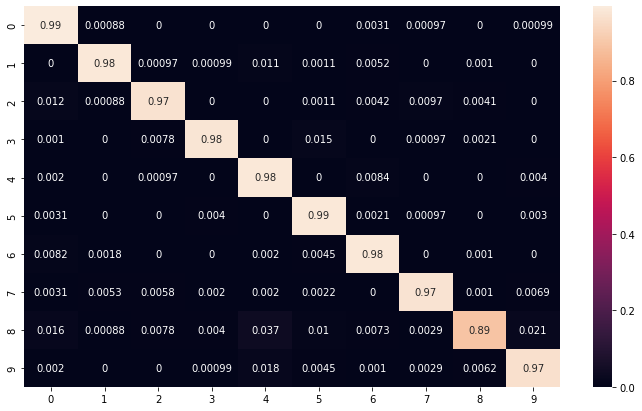

In [39]:
# Build confusion matrix
cm_mat = confusion_matrix(ytrue, ypred)
df_cm = pd.DataFrame(cm_mat / np.sum(cm_mat, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig('output.png')